# 데이터 다루기

## 10.1 데이터 탐색하기
모델을 만들어 해답을 찾기 전 가장 먼저 해야하는 일은 데이터를 탐색하는 것이다.

### 10.1.1 1차원 데이터 탐색하기
가장 간단한 경우는 단순히 숫자로만 구성된 1차원 데이터가 주어졌을 때이다. \
가장 먼저 **요약 통계치(summary statistics)**를 계산해야 한다. 데이터의 개수, 최솟값, 최댓값, 평균, 표준편차를 알아볼 필요가 있다. \
요약 통계치가 무의미한 경우, 범위를 몇 개의 구간으로 나누고 각 구간 안의 데이터 개수를 살펴보는 히스토그램을 만들자.

In [1]:
from typing import List, Dict
from collections import Counter
import math
import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """각 데이터를 bucket_size의 배수에 해당하는 구간에 위치시킨다."""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """구간을 생성하고 각 구간 안의 데이터 개수를 계산해 준다."""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [2]:
import random
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                      mu: float = 0,
                      sigma: float = 1,
                      tolerance: float = 0.00001) -> float:
    """이진 검색을 사용해 역함수를 근사"""
    # 표준정규분포가 아니라면 표준정규분포로 변환
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z = -10.0  # normal_cdf(-10)은 0에 근접
    hi_z = 10.0  # normal_cdf(10)은 1에 근접
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2  # 중간 값
        mid_p = normal_cdf(mid_z)  # 중간 값의 누적분포 값을 계산
        if mid_p < p:
            low_z = mid_z  # 중간 값이 너무 작다면 더 큰 값들을 검색
        else:
            hi_z = mid_z  # 중간 값이 너무 크다면 더 작은 값들을 검색
    
    return mid_z

In [3]:
random.seed(0)

# -100 ~ 100 사이의 균등분포
uniform = [200 * random.random() - 100 for _ in range(10000)]

# 평균이 0이고 표준편차가 57인 정규분포
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

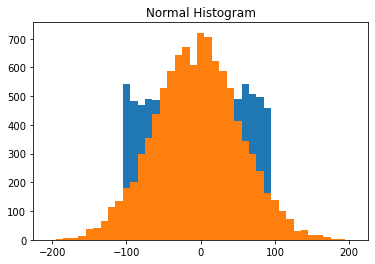

In [4]:
# 위의 두 데이터 모두 평균이 0이고 표준편차가 대략 58이지만 굉장히 다른 모양의 분포를 띈다.

plot_histogram(uniform, 10, "Uniform Historgram")
plot_histogram(normal, 10, "Normal Histogram")

두 분포의 최솟값과 최대값이 상당히 다르긴 하지만, 이것만으로도 두 분포의 차이를 이해하기는 쉽지 않다.

### 10.1.2 2차원 데이터
2차원 데이터가 주어졌다고 해보자. 사용자가 하루 평균 사이트에서 보내는 시간뿐 아니라 사용자의 데이터 과학 경력까지 주어졌다. \
아래와 같은 데이터가 주어졌다고 해보자

In [5]:
def random_normal() -> float:
    """표준 정규 분포를 따르는 임의의 데이터를 반환"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

ys1, ys2의 histogram은 비슷하다(평균과 표준편차가 동일하기 때문이다). xs에 대한 결합확률분포(joint distribution)의 모양은 상당히 다르다.

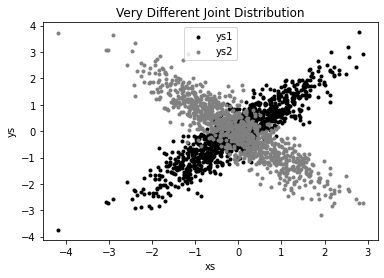

In [6]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distribution")
plt.show()

상관관계를 통해 차이를 확인할 수도 있다.

In [7]:
import math
from typing import List
from typing import Callable

Vector = List[float]
Matrix = List[List[float]]

def make_matrix(num_rows: int, num_cols: int, entry_fn: Callable[[int, int], float]) -> Matrix:
    """(i, j)번째 원소가 entry_fn(i, j)인 num_rows x num_cols 리스트를 반환"""
    return [[entry_fn(i, j) for j in range(num_cols)] for i in range(num_rows)]

def covariance(xs: List[float], ys: List[float]) -> float:
    assert len(xs) == len(ys),  "xs and ys must have same number of elements"
    return dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)

def dot(v: Vector, w: Vector) -> float:
    """v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w),  "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v: Vector) -> float:
    """v_1 * v_1 + ... v_n * v_n"""
    return dot(v,v)

def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

def de_mean(xs: List[float]) -> List[float]:
    """x의 모든 데이터 포인트에서 평균을 뺌(평균을 0으로 만들기 위해)"""
    x_bar = mean(xs)
    return [x - x_bar for x in xs]

def variance(xs: List[float]) -> float:
    """편차의 제곱의 평균"""
    assert len(xs) >= 2, "variance requires at least two elements"
    
    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(xs: List[float]) -> float:
    """표준편차는 분산의 제곱근"""
    return math.sqrt(variance(xs))

def correlation(xs: List[float], ys: List[float]) -> float:
    """xs와 ys의 값이 각각의 평균에서 얼마나 멀리 떨어져 있는지 계산"""
    stdev_x = standard_deviation(xs)
    stdev_y = standard_deviation(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs, ys) / stdev_x / stdev_y
    else:
        return 0  #  편차가 존재하지 않는다면 상관관계는 0

In [8]:
print(correlation(xs, ys1))
print(correlation(xs, ys2))

0.9010493686379609
-0.8920981526880033


### 10.1.3 다차원 데이터
다차원 데이터의 경우 각 차원이 서로 어떻게 연관되어 있는지 살펴볼 수 있다. 가장 간편한 방법은 상관관계 행렬을 살펴보는 것이다. 상관관계 행렬의 i번째 행과 j번째 열에 해당하는 값은 i번째 차원과 j번째 차원의 상관관계를 나타낸다.

In [9]:
def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    (i, j)번째 항목이 data[i]와 data[j]의 상관관계를 나타내는
    len(data) x len(data) 행렬을 반환함
    """
    def correlation_ij(i:int, j: int) -> float:
        return correlation(data[i], data[j])
    
    return make_matrix(len(data), len(data), correlation_ij)

만약, 차원은 수가 많지 않다면 **산포도 행렬(scatterplot matrix)**을 이용해서 각 차원의 쌍별로 산포도를 시각화할 수 있다. plt.subplots를 사용하면 차트 안에 하위 차트를 생성할 수 있다. plt.subplots에 행과 열을 입력하면 figure 객체와 2차원 axes 객체를 반환해 준다.

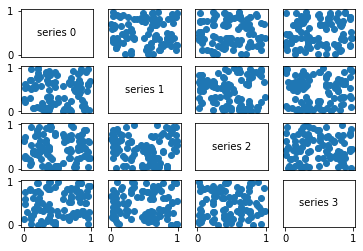

In [10]:
# corr_data는 100차원 벡터 네 개를 포함하고 있는 리스트다.
import numpy as np
import random
corr_data = [[np.random.random() for i in range(100)] for i in range(4)]
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        # x축은 j번째 열을, y축은 i번째 행을 나타내는 산포도
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])
        
        # 만약 i == j, series라는 제목 출력
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                               xycoords = "axes fraction",
                               ha="center", va="center")
        
        # 왼쪽과 밑에 위치한 치트에만 축 레이블 명시
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
            
# 밑에서 가장 오른쪽 그리고 왼쪽 가장 위에 위치한 차트 안에는 문자열만 있기 때문에
# 축 레이블을 고정

ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

## 10.2 NamedTuple 사용하기
흔히 데이터를 딕셔너리로 표현한다.

In [11]:
import datetime
stock_price = {'closing_price': 102.06,
              'date': datetime.date(2014, 8, 29),
              'symbol': 'AAPL'}

이런 표현 방식은 여러 이유로 이상적이지 않다. 딕셔너리는 약간의 오버헤드(overhead)가 있는 비효율적인 표현 방식이기에 많은 수의 주가 정보가 있다면 필요 이상의 많은 메모리를 차지할 것이다. 딕셔너리로 데이터에 접근할 때 오류를 일으키기 쉽다. 
아래의 코드는 오류없이 실행되지만 의도치 않은 행동을 한다.

In [12]:
stock_price['closing_price'] = 103.06

type annotation을 사용하여 딕셔너리를 표기할 수 있다.

In [13]:
prices: Dict[datetime.date, float] = {}

다양한 타입의 값을 들고 있는 딕셔너리를 표현할 수 있는 좋은 어노테이션 방법은 없다. 즉, 타입을 명시해 주는 타입 어노테이션의 본 기능을 제대로 활용할 수 없게 된다. 대안으로 Python은 튜플과 비슷하지만 명명할 수 있는 공간을 지닌 **namedtuple** 모듈을 제공한다.

In [14]:
from collections import namedtuple

StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03

튜플처럼 namedtuple 또한 생성된 이후 값을 수정할 수 없다. 때대로 이는 불편할 때도 있지만 좋은 속성이다.

In [15]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float
    
    def is_high_tech(self) -> bool:
        """클래스이기 때문에 메서드를 추가할 수 있다."""
        return self.symbol in ["MSFT", "GOOG", "FB", "AMZN", "AAPL"]

price = StockPrice("MSFT", datetime.date(2018, 12, 14), 106.03)

assert price.symbol == "MSFT"
assert price.closing_price == 106.03
assert price.is_high_tech()

## 10.3 Dataclasses
Dataclasses는 마치 NamedTuple의 가변적인 버전처럼 동작한다. 문법은 NamedTuple과 매우 유사하다. 하지만 base class에서 상속을 받는 대신 **decorator**를 사용한다.

In [16]:
from dataclasses import dataclass
@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float
    
    def is_high_tech(self) -> bool:
        """클래스이므로 메서드를 추가할 수 있다."""
        return self.symbol in ["MSFT", "GOOG", "FB", "AMZN", "AAPL"]

price2 = StockPrice2("MSFT", datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == "MSFT"
assert price2.closing_price == 106.03
assert price2.is_high_tech()

NamedTuple과 dataclasses의 가장 큰 차이는 dataclasses의 인스턴스 **값을 수정할 수 있다는 점**이다.

In [17]:
# 주식 분할
price2.closing_price /= 2
assert price2.closing_price == 51.03

AssertionError: 

위의 코드는 오류가 난다. 딕셔너리를 사용하지 않음으로서 피하고자 했던 오류에 동일하게 취약할 것이다.

In [18]:
# 일반적인 클래스이니 새 필드를 원하는 대로 추가할 수 있다.
price2.closing_price = 75

## 10.4 정제하고 합치기
실제 데이터는 굉장히 지저분하다. 보통 데이터를 사용하기 전에 정제하는 과정을 거쳐야 한다. 앞장의 예시처럼 문자열을 float이나 int로 변환해야한다. 누락된 값, 이상치나 잘못된 데이터가 있는지 확인해야 한다.

In [19]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                     date=parse(date).date(),
                     closing_price=float(closing_price))

In [20]:
# 함수를 테스트
stock = parse_row(["MSFT", "2018-12-14", "106.03"])
assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

만약 '나쁜'데이터가 포함되어 있다면 어떤 일이 발생할까? 데이터에 숫자가 아닌 float값이 포함되어 있으면 어떻게 될까? 코그다 오류로 인해 종료되는 것보다는 None으로 파싱되는 것이 나을 수 있다.

In [21]:
from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row
    
    # 주가 심벌은 모두 대문자로 구성되어 있다.
    if not re.match(r"^[A-Z]+$", symbol):
        return None
    
    try:
        date = parse(date_).date()
    except ValueError:
        return None
    
    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None
    
    return StockPrice(symbol, date, closing_price)

In [22]:
# error가 발생하면 None을 반환한다.
assert try_parse_row(["MSFT0", "2018-12-14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12--14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12-14", "x"]) is None

In [23]:
# 만약 올바른 데이터라면 이전과 동일한 결과가 나와야 한다.
assert try_parse_row(["MSFT", "2018-12-14", "106.03"]) == stock

데이터를 불러와 유효한 행만 파싱을 한다.

In [24]:
import csv
data: List[StockPrice] = []

with open("comma_delimited_stock_prices.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"skipping invalid row: {row}")
        else:
            data.append(maybe_stock)

FileNotFoundError: [Errno 2] No such file or directory: 'comma_delimited_stock_prices.csv'

In [25]:
print(data)

[]


유효하지 않은 데이터를 어떻게 처리할지 결정하면 된다. 나쁜 데이터를 처리하는 방법은 크게 세 가지 이다.
1. 나쁜 데이터를 제거하거나,
2. 직접 수정하거나,
3. 나쁜 데이터가 없기를 기도하는 방법 \

만약에 백만개의 행 중 나쁜 데이터가 한개라면 무시해도 괜찮을 것이다. 하지만 행의 절반이 나쁜 데이터라면 반드시 해결해야 한다.\
위 데이터에 ' StockPrice(symbol='FB', date=datetime.date(3014, 6, 20), closing_price=64.5)' 3014라는 이상치가 들었는데 정상적으로 파싱이 되었다. 이러한 것을 수정해야 한다.

## 10.5 데이터 처리
데이터를 처리하는 기술은 가장 중요한 기술 중 하나이다. \
예를 들어 데이터가 아래와 같이 주어지면 \

data = [StockPrice(symbol='MSFT', data=datatime.date(2018,12,24), closing_price=106.03),...] \

데이터를 처리할 수 있는 **패턴**이 보일 것이다. \
예를 들어 AAPL 종가의 최고치를 다음과 같은 단계로 찾아볼 수 있다.
1. 살펴볼 데이터를 AAPL에 관한 행으로 한정한다.
2. 각 행에서 closing_price를 갖고 온다.
3. closing_priced의 max를 찾는다. \
이 모든 것은 list comprehension으로 처리 가능하다.

In [26]:
max_appl_price = max(stock_price.closing_price for stock_price in data if stock_price.symbol == "AAPL")
print(max_appl_price)

ValueError: max() arg is an empty sequence

1. 최고가를 추적하는 딕셔너리를 생성한다(빈 값에 대해 마이너스 무한대를 반환하는 defaultdict를 사용하여 다른 어떤 가격도 이보다 크도록 할 것이다.)
2. 데이터를 순회하며 이를 갱신한다.

In [27]:
from collections import defaultdict

max_prices: Dict[str, float] = defaultdict(lambda: float('-inf'))

for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prcies[symbol]:
        max_prices[symbol] = closing_price

이 주가 데이터에서 변화율은 price_today / price_yesterday - 1이라는 식으로 정의가 가능하다. 이 말은 변화율을 계산하기 위해서 당일 주가와 전일 주가를 연결시켜야 한다. symbol을 기준으로 주가를 그룹화하고 각 그룹 안에서 아래와 같은 절차를 걸친다.

1. 주가를 날짜 기준으로 정렬
2. zip을 사용해서 주가를 (전일, 당일)쌍으로 변환
3. 각 쌍을 사용해서 새로운 '변화율'행 생성

In [28]:
# 주가를 심벌 기준으로 묶기
from typing import List
from collections import defaultdict

# symbol별 주가 수집
prices: Dict[str, List[StockPrice]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].append(sp)
    
print(prices)

defaultdict(<class 'list'>, {})


모든 주가는 tuple로 표현되기에 각 필드의 순서대로 정렬될 것이다. 먼저 심벌, 날짜, 주가 순으로 정렬될 것이다.

In [29]:
# 가격을 날짜로 정렬
prices = {symbol: sorted(symbol_prices) for symbol, symbol_prices in prices.items()}
print(prices)

{}


In [30]:
# 일별 변화율 계산 함수
def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return today.closing_price / yesterday.closing_price - 1

class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_change: float

def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    """주가는 하나의 주식에 대응되며 정렬되어 있다고 가정"""
    return [DailyChange(symbol=today.symbol,
           date=today.date,
           pct_change=pct_change(yesterday, today)) for yesterday, today in zip(prices, prices[1:])]

# 모두 합치면
all_changes = [change for symbol_prices in prices.values() for change in day_over_day_changes(symbol_prices)]

# 최대 변화율
max_change = max(all_changes, key=lambda change: change.pct_change)

# 최소 변화율
min_change = min(all_changes, key=lambda change: change.pct_change)

ValueError: max() arg is an empty sequence

In [31]:
# 월별 평균 일일 변화율
changes_by_month: List[DailyChange] = {month: [] for month in range(1,13)}

for change in all_changes:
    changes_by_month[change.date.month].append(change)
    
avg_daily_change = {
    month: sum(change.pct_change for change in changes) / len(changes)
    for month, changes in changes_by_month.items()
}

ZeroDivisionError: division by zero

## 10.6 척도 조절
대부분의 데이터 과학 기법은 데이터의 **척도(scale)**에 민감하게 반응한다. \
예를 들어 수백 명의 키와 몸무게가 주어졌고, 이를 통해 체형을 군집해야한다고 해보자. \
직관적으로 가까운 데이터는 가까운 군집에 포함되어야 한다. 그러기 위해서는 데이터간의 **거리**를 정의해야 한다. \
유클리드 거리 함수 distance를 사용하기 위해 데이터를 2차원 평면의 점으로 여기자

In [32]:
def add(v: Vector, w: Vector) -> Vector:
    """각 성분끼리 더한다."""
    assert len(v) == len(w), "vector must be the same length"
    
    return [v_i + w_i for v_i, w_i in zip(v, w)]

def subtract(v: Vector, w: Vector) -> Vector:
    """각 성분끼리 뺀다."""
    assert len(v) == len(w), "vectors must be the same length"
    
    return [v_i - w_i for v_i, w_i in zip(v, w)]
def dot(v: Vector, w: Vector) -> float:
    """v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w),  "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v: Vector) -> float:
    """v_1 * v_1 + ... v_n * v_n"""
    return dot(v,v)

def squared_distance(v: Vector, w: Vector) -> float:
    """(v_1 - w_1)**2 + ... + (v_n - w_n)**2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """벡터 v와 w 간의 거리를 계산"""
    return math.sqrt(squared_distance(v,w))

In [33]:
import pandas as pd
height_weight_data = pd.DataFrame(data={"person": ['A', 'B', 'C'], 
                                        "height(inch)": [63, 67, 70], 
                                        "height(cm)": [160, 170.2, 177.8],
                                        "weight(pound)": [150, 160, 171]})
height_weight_data

,person,height(inch),height(cm),weight(pound)
0,A,63,160.0,150
1,B,67,170.2,160
2,C,70,177.8,171


In [34]:
a_to_b = distance([63, 150], [67, 160])  # 10
a_to_c = distance([63, 150], [70, 171])  # 22
b_to_c = distance([67, 160], [70, 171])  # 11
print("a_to_b:", a_to_b, "a_to_c:", a_to_c, "b_to_c:", b_to_c)
# B와 가장 비슷한 체형은 distance가 가장 작은 A이다.

a_to_b: 10.770329614269007 a_to_c: 22.135943621178654 b_to_c: 11.40175425099138


In [35]:
# height(cm)를 사용하면 B와 가장 비슷한 사람은 distance가 가장 작은 C이다.
a_to_b = distance([160, 150], [170.2, 160])  # 14
a_to_c = distance([160, 150], [177.8, 171])  # 27
b_to_c = distance([170.2, 160], [177.8, 171])  # 13
print("a_to_b:", a_to_b, "a_to_c:", a_to_c, "b_to_c:", b_to_c)

a_to_b: 14.284257068535268 a_to_c: 27.52889391167034 b_to_c: 13.370115930686627


키의 **척도**에 따라 결과가 달라지는 문제가 발생한다.\
각 차원의 수치가 크게 다른 경우, 각 차원의 평균을 0, 표준편차를 1로 변환시키면서 척도를 조절해줄 수 있다. 척도를 조절하면 단위는 제거되고, 각 차원은 '평균으로 부터 몇 표준편차만큼 떨어져 있는지"로 변환된다. \
먼저 각 열의 평균 mean과 표준편차 standard_deviation을 계산해 보자.

In [36]:
import math
from typing import Tuple

# 앞장에서 만들어 놓은 함수
def scalar_multiply(c: float, v: Vector) -> Vector:
    """모든 성분을 c로 곱하기"""
    return [c * v_i for v_i in v]

def vector_mean(vectors: List[Vector]) -> Vector:
    """각 성분별 평균을 계산"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def standard_deviation(xs: List[float]) -> float:
    """표준편차는 분산의 제곱근"""
    return math.sqrt(variance(xs))

def variance(xs: List[float]) -> float:
    """편차의 제곱의 평균"""
    assert len(xs) >= 2, "variance requires at least two elements"
    
    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1)

def vector_sum(vectors: List[Vector]) -> Vector:
    """모든 벡터의 각 성분들끼리 더한다."""
    # vectors가 비어있는지 확인
    assert vectors, "no vectors provided"
    
    # 모든 벡터의 길이가 동일한지 확인
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"
    
    # i번째 결과값은 모든 벡터의 i번째 성분을 더한 값
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

In [37]:
def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """각 열의 평균과 표준편차를 반환"""
    dim = len(data[0])
    
    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data] for i in range(dim))]
    
    return means, stdevs

In [40]:
vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)
assert means == [-1, 0, 1]
assert stdev == [2, 1, 0]

TypeError: object of type 'generator' has no len()

In [41]:
# 계산된 평균과 표준편차를 사용해서 새로운 데이터 행렬을 만들어 보자
def rescale(data: List[Vector]) -> List[Vector]:
    """각 열의 평균을 0, 표준편차를 1로 볁환하면서
    입력되는 데이터의 척도를 조절
    편차가 없는 열은 그래로 유지"""
    dim = len(data[0])
    means, stdevs = scale(data)
    
    # 각 벡터에 복사본을 생성
    rescaled = [v[:] for v in data]
    
    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i] / stdevs[i])
    return rescaled

In [43]:
means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]

TypeError: object of type 'generator' has no len()

## 10.7  한편으로: tqdm
간혹 시간이 오래 걸리는 연산을 할 때가 있다. 이런 경우, 이런 경우, 작업이 진행되고 있는지 혹은 얼마나 더 기다려야 하는지 알고 싶을 것이다. \
진행표시줄을 생성해주는 tqdm 라이브러리를 사용해 이를 확인할 수 있다. (pip install tqdm 명령어를 통해 설치 가능) \
알아야 할 기능
1. 이터러블(iterable, 하나씩 차례로 반환 가능한 객체)을 tqdm.tqdm으로 감싸면 진행표시줄이 생성된다는 점이다.
2. 

In [46]:
import tqdm

for i in tqdm.tqdm(range(100)):
    _ = [random.random() for _ in range(100000)]

100%|██████████| 100/100 [00:00<00:00, 108.39it/s]


얼마나 진행되었는지, 얼마나 남았는지 확인이 가능하다. 앞의 예시 처럼 range를 감싸거나, tqdm.trange를 사용할 수 있다. \
tqdm 이터레이터를 with문으로 감싸면 진행표시줄의 설명도 설정할 수 있다.

In [47]:
from typing import List

def primes_up_to(n: int) -> List[int]:
    primes = [2]
    
    with tqdm.trange(3, n) as t:
        for i in t:
            # i가 더 작은 소수로 나뉘지 않는다면 수수다.
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)
            
            t.set_description(f"{len(primes)} primes")
    return primes

my_primes = primes_up_to(100_000)

429 primes:   3%|▎         | 2941/99997 [00:01<01:07, 1430.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

928 primes:   7%|▋         | 7146/99997 [00:04<01:02, 1476.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

1399 primes:  12%|█▏        | 11599/99997 [00:07<01:00, 1456.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limi

## 10.8 차원 축소
가끔씩 데이터의 '실제(or 유용한)' 차원은 주어진 데이터의 차원과 다를 수 있다. \
**주성분 분석(principal component analysis)** 라는 기술을 통해 데이터의 편차를 최대한 포착하는 차원을 찾아낼 수 있다. \
가장 먼저 각 차원의 평균이 0이 되도록 데이터를 바꿔 보자.

In [48]:
def de_mean(data: List[Vector]) -> List[Vector]:
    """모든 차원의 평균이 각각 0이 되도록 재정렬"""
    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]

만약 데이터를 이렇게 변환하지 않는다면 주성분 분석은 데이터의 편차보다는 데이터의 평균을 잡아낼 것이다. \
평균이 제거된 행렬 X가 주어진 상태라면 이제 어떤 방향이 데이터의 편차를 가장 많이 잡아내는지 알아볼 수 있다.
만약 방향 d(크기가 1인 벡터)가 주어졌다면 행렬의 각 행 x는 d 방향으로 dot(x, d)만큼 늘어날 것이다. 그리고 0이 아닌 모든 벡터 w의 크기를 1로 변환하면 w는 방향을 나타낼 것이다.

In [50]:
def magnitude(v: Vector) -> float:
    """벡터 v의 크기를 반환"""
    return math.sqrt(sum_of_squares(v))  # math.sqrt는 제곱근을 계산해 주는 함수

In [51]:
def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

In [52]:
def direactional_variance(data: List[Vector], w: Vector) -> float:
    """
    w가 가리키는 방향에서 x의 편차를 반환
    """
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

편차를 최대화시키는 방향을 찾기 위해 경사 하강법을 사용할 수 있다.

In [53]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    w에 관한 특정 방향의 편차의 그래디언트
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data) for i in range(len(w))]

제 1 주성분은 directional_variance 함수를 최대화시키는 방향이다.

In [54]:
def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """v에서 step_size만큼 이동하기"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

In [55]:
def first_principal_component(data: List[Vector],
                             n: int = 100,
                             step_size: float = 0.1) -> Vector:
    # 임의로 추측한 위치에서 시작
    guess = [1.0 for _ in data[0]]
    
    with tqdm.trange(n) as t:
        for _ in t:
            dv = direactional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv: .3f}")
    
    return direction(guess)

제 1 주성분의 방향을 찾았다면 데이터를 주성분에 투영시켜서 해당 성분의 값을 찾을 수 있다.

In [56]:
def scalar_multiply(c: float, v: Vector) -> Vector:
    """모든 성분을 c로 곱하기"""

In [57]:
def project(v: Vector, w: Vector) -> Vector:
    """v를 w방향으로 투영"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

다른 성분을 찾고 싶다면 먼저 투영된 데이터를 제거해야 한다.

In [59]:
def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """v에서 v를 w로 투영시킨 결과를 빼준다."""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

2차원 데이터를 예제로 사용했기에 데이터에서 제 1 주성분을 제거하면 남아 있는 데이터는 1차원일 것이다. \
고차원 데이터에서는 이러한 반복적인 과정을 반복해서 원하는 만큼 많은 주성분을 찾을 수 있다. \

In [60]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)
        
    return components

계산된 성분을 사용하면 주어진 데이터를 저차원 공간에서 생성시킬 수 있다.

In [61]:
def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

차원 축소가 중요한 이유
1. 잡음에 해당되는 차원을 제거해 주고 밀접하게 연관된 차원을 합쳐 주면서 데이터를 정제해 준다.
2. 저차원으로 축소시킨 데이터에서는 고차원 데이터에서 사용할 수 없었던 다양한 기법을 사용할 수 있게 된다. \
차원 축소를 통해 더 좋은 모형을 만들 수 있다고는 해도, 만들어진 모형을 해석하는 게 어려워진다. \
e.g. '경력이 1년 증가할수록 연봉은 평균적으로 $10,000 증가한다.'는 쉽게 이해할 수 있지만, '제3 주성분이 0.1 만큼 증가할수록 연봉은 평균적으로 $10,000 증가한다.'는 결론을 해석하기는 훨씬 힘들다.

## PCA?